In [1]:
def load_aws_credentials(profile_name):
    "Returns (access_key, secred_key) from ~/.aws/credentials for the given profile."
    import boto3
    ses = boto3.Session(profile_name=profile_name)
    creds = ses.get_credentials()
    return (creds.access_key, creds.secret_key)

In [2]:
import neuropythy as ny

ny.config['hcp_credentials'] = load_aws_credentials('hcp')

filename = '/home/jovyan/shared/HCP/115825/MNINonLinear/Results/tfMRI_MOVIE2_7T_PA/tfMRI_MOVIE2_7T_PA_Atlas_1.6mm_MSMAll_hp2000_clean.dtseries.nii'
cii = ny.load(filename)
(lh_bold, rh_bold, subcortex_bold) = ny.hcp.cifti_split(cii)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [3]:
lh_bold.shape

(918, 59292)

In [4]:
import numpy as np
import matplotlib.pyplot as plt

sid = 111312
sub = ny.hcp_subject(sid)
lh = sub.hemis['lh_LR59k']
rh = sub.hemis['rh_LR59k']
view_pos = np.array([0, 100.0, 0])
lh_mproj_front = ny.map_projection(chirality='lh', registration='fs_LR', center=view_pos, radius=np.pi/2)
lh_mproj_back = ny.map_projection(chirality='lh', registration='fs_LR', center=-view_pos, radius=np.pi/2)
rh_mproj_front = ny.map_projection(chirality='rh', registration='fs_LR', center=view_pos, radius=np.pi/2)
rh_mproj_back = ny.map_projection(chirality='rh', registration='fs_LR', center=-view_pos, radius=np.pi/2)
lh_fmap_front = ny.to_flatmap(lh_mproj_front, lh)
lh_fmap_back = ny.to_flatmap(lh_mproj_back, lh)
rh_fmap_front = ny.to_flatmap(rh_mproj_front, rh)
rh_fmap_back = ny.to_flatmap(rh_mproj_back, rh)

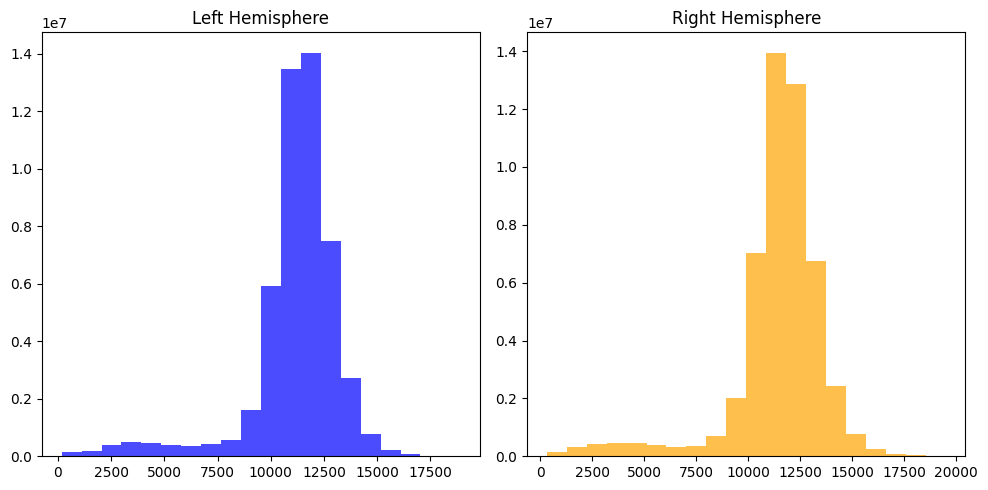

In [6]:
# Flatten the array of the first subject
flattened_lh = lh_bold.flatten()
flattened_rh = rh_bold.flatten()

# Plot histogram of BOLD values to get max and min
plt.figure(figsize=(10, 5))  # Adjust figure size if needed

plt.subplot(1, 2, 1)
plt.hist(flattened_lh, bins=20, color='blue', alpha=0.7)
plt.title('Left Hemisphere')

plt.subplot(1, 2, 2)
plt.hist(flattened_rh, bins=20, color='orange', alpha=0.7)
plt.title('Right Hemisphere')

plt.tight_layout()
plt.show()

In [7]:
def sub_channel(lh_data, rh_data):
    (fig, axs) = plt.subplots(2, 2, figsize=(2,2), dpi=72*4)
    ny.cortex_plot(lh_fmap_front, axes=axs[0,0], color=lh_data[lh_fmap_front.labels], cmap='gray',
                   vmin = 0, vmax = 17500)
    ny.cortex_plot(lh_fmap_back, axes=axs[1,0], color=lh_data[lh_fmap_back.labels], cmap='gray',
                   vmin = 0, vmax = 17500)
    ny.cortex_plot(rh_fmap_front, axes=axs[0,1], color=rh_data[rh_fmap_front.labels], cmap='gray',
                   vmin = 0, vmax = 17500)
    ny.cortex_plot(rh_fmap_back, axes=axs[1,1], color=rh_data[rh_fmap_back.labels], cmap='gray',
                   vmin = 0, vmax = 17500)
    fig.subplots_adjust(0,0,1,1,0,0)
    for ax in axs.flatten():
        ax.axis('off')
    return fig

# vmin and vmax options shoudl include bulk of BOLD values. 
# take image matrices and flatten and plot as histogram

In [8]:
import os

# Scrape HCP folder for subject IDs. Outputs a list of subject IDs
subj_id = []
path = '/home/jovyan/shared/HCP/'
for dir in os.listdir(path):
    parts = dir.split('.')
    subj_id.append(parts[0])
    # using list comprehension + enumerate() to remove duplicated from list
subj_id = [i for n, i in enumerate(subj_id) if i not in subj_id[:n]]
print(subj_id)

['115825']


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


shape of image matrix 0:  (250, 250)
shape of image matrix 1:  (250, 250)
shape of image matrix 2:  (250, 250)
Shape of the stacked matrix: (250, 250, 3)


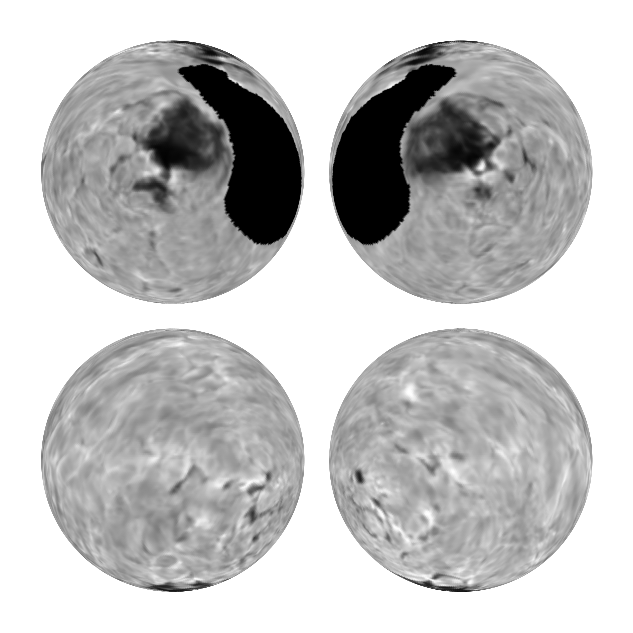

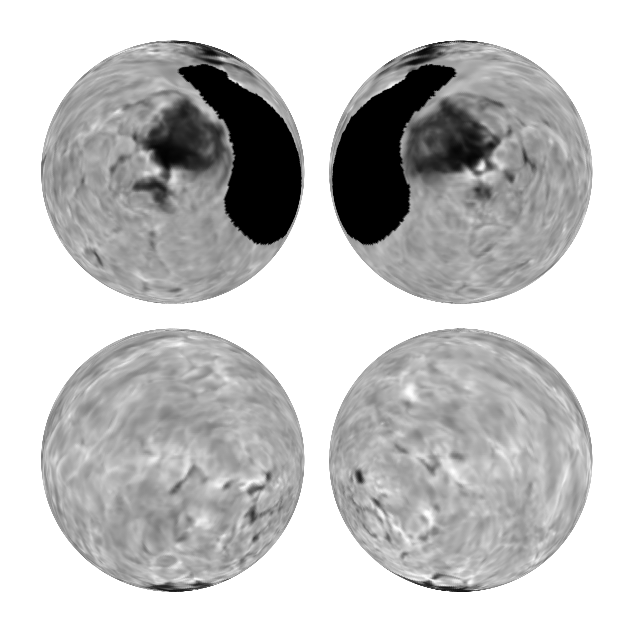

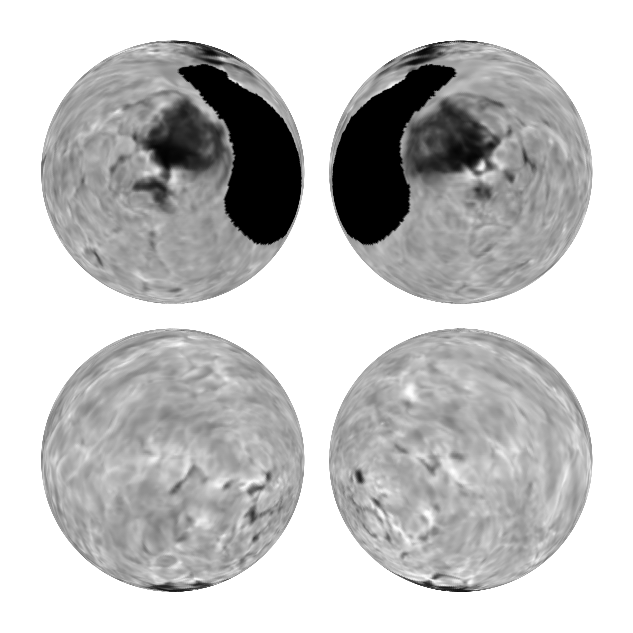

In [15]:
import skimage as sp
from PIL import Image

chunk_size = 5
img_matrices = []

for sid in subj_id:
    filename = path + sid + '/MNINonLinear/Results/tfMRI_MOVIE2_7T_PA/tfMRI_MOVIE2_7T_PA_Atlas_1.6mm_MSMAll_hp2000_clean.dtseries.nii'
    cii = ny.load(filename)
    (lh_bold, rh_bold, subcortex_bold) = ny.hcp.cifti_split(cii)
    tr = lh_bold.shape[0]
    lh_bold_new = []
    rh_bold_new = []
    
    for i in range(0, tr, chunk_size): # averages over every 5 TRs
        
        lh_chunk = lh_bold[i:i+chunk_size, :]
        lh_chunk_mean = np.mean(lh_chunk, axis=0)
        lh_bold_new.append(lh_chunk_mean)
        
        rh_chunk = rh_bold[i:i+chunk_size, :]
        rh_chunk_mean = np.mean(rh_chunk, axis=0)
        rh_bold_new.append(rh_chunk_mean)
        
    for t in range(3):
        avg_img = sub_channel(lh_bold_new[t], rh_bold_new[t])
        plt.savefig(str(sid) + '_' + str(t) + '.png', dpi = 125)
        
        # Open the RGBA image
        image_path = str(sid) + '_' + str(t) + '.png'
        rgba_image = Image.open(image_path)

        # Convert the RGBA image to grayscale
        grayscale_image = rgba_image.convert('L')

        # Save the grayscale image
        output_path = str(sid) + '_' + str(t) + '_gs.png'
        grayscale_image.save(output_path)
        
        im_mtx = sp.io.imread(output_path)
        print("shape of image matrix " + str(t) + ": ", im_mtx.shape)
        img_matrices.append(im_mtx)
        
stacked_matrix = np.stack(img_matrices, axis=2)
print("Shape of the stacked matrix:", stacked_matrix.shape)
#        ny.save.nifti(filename)
#        ny.load(image_array)